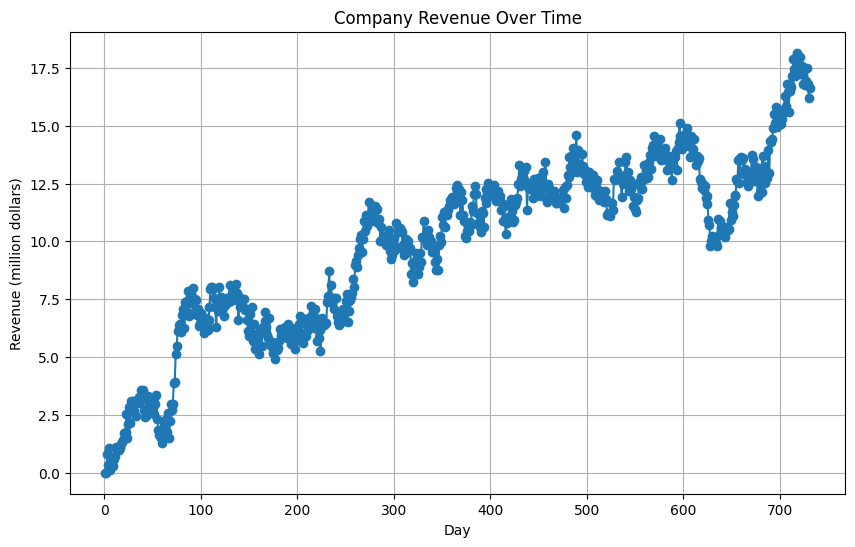

Length: 731 days
Missing days: 0


In [211]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
import numpy as np

!pip install scipy
import scipy.signal as signal

from sklearn.model_selection import train_test_split

#C1
# Load the data
data = pd.read_csv('teleco_time_series.csv')

# Plotting the time series
plt.figure(figsize=(10, 6))
plt.plot(data['Day'], data['Revenue'], marker='o', linestyle='-')
plt.title('Company Revenue Over Time')
plt.xlabel('Day')
plt.ylabel('Revenue (million dollars)')
plt.grid(True)
plt.show()

# Check the time step formatting
min_day = data['Day'].min()
max_day = data['Day'].max()

# Create a list
expected_days = set(range(min_day, max_day + 1))

# Find missing days
missing_days = list(expected_days - set(data['Day']))

# Length of the sequence
sequence_length = len(data)
print(f"Length: {sequence_length} days")
print(f"Missing days: {sum(missing_days)}")


In [212]:

# Perform Augmented Dickey-Fuller test
result = adfuller(data['Revenue'])

# Print test results
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(f'    {key}: {value}')


ADF Statistic: -1.924612157310181
p-value: 0.3205728150793977
Critical Values:
    1%: -3.4393520240470554
    5%: -2.8655128165959236
    10%: -2.5688855736949163


In [213]:
#C4
print(data.isnull().sum())
data.describe()

# Differencing the series
data['Revenue_diff'] = data['Revenue'].diff()
data.dropna(inplace=True)

# Perform Augmented Dickey-Fuller test on the differenced series (Kang, 2020)
result_diff = adfuller(data['Revenue_diff'])

# Print ADF test results
print('ADF Statistic (Differenced):', result_diff[0])
print('p-value (Differenced):', result_diff[1])
print('Critical Values (Differenced):')
for key, value in result_diff[4].items():
    print(f'    {key}: {value}')

# Save
data.to_csv('cleaned_teleco_time_series.csv', index=False)



Day        0
Revenue    0
dtype: int64
ADF Statistic (Differenced): -44.874527193875984
p-value (Differenced): 0.0
Critical Values (Differenced):
    1%: -3.4393520240470554
    5%: -2.8655128165959236
    10%: -2.5688855736949163


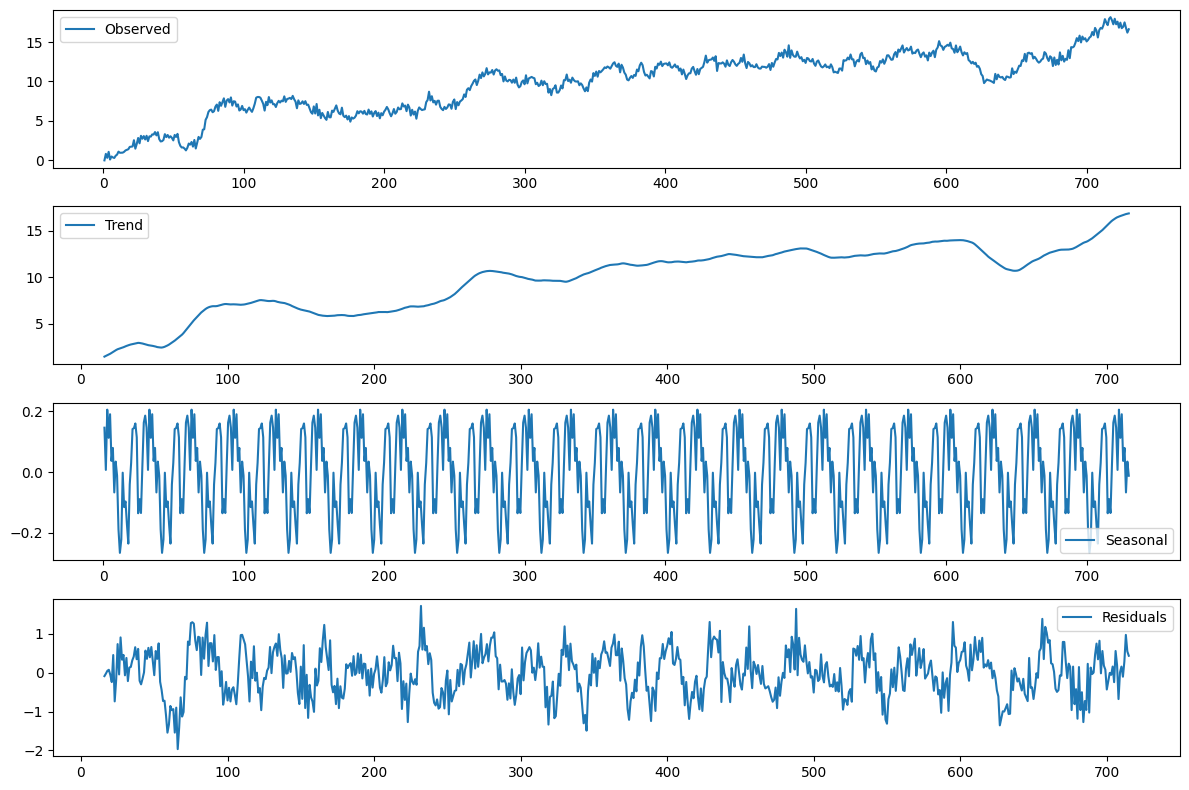

In [214]:



# Convert Day column to index
data['Day'] = pd.to_datetime(data['Day'])

# Perform seasonal decomposition
result = seasonal_decompose(data['Revenue'], model='additive', period=30)

# Plot the seasonal decomposition results
plt.figure(figsize=(12, 8))

plt.subplot(411)
plt.plot(result.observed, label='Observed')
plt.legend()

plt.subplot(412)
plt.plot(result.trend, label='Trend')
plt.legend()

plt.subplot(413)
plt.plot(result.seasonal, label='Seasonal')
plt.legend()

plt.subplot(414)
plt.plot(result.resid, label='Residuals')
plt.legend()

plt.tight_layout()
plt.show()


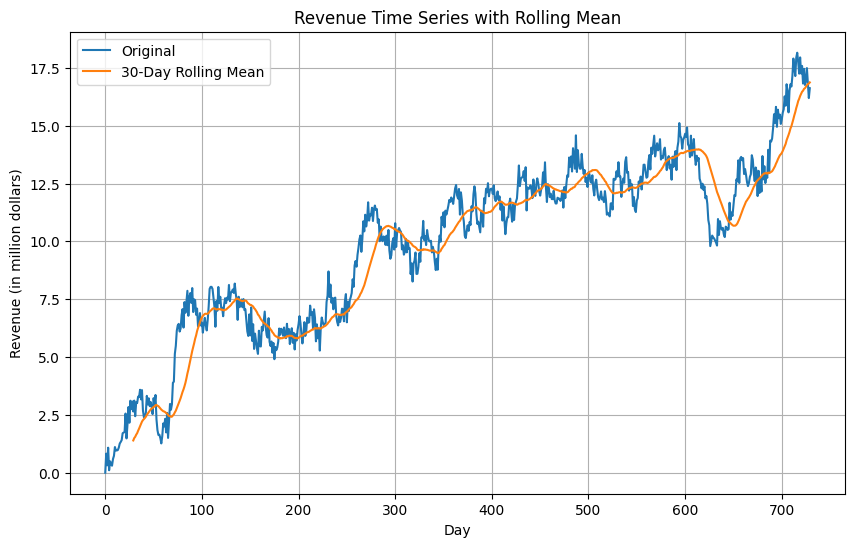

In [215]:
# Trend Analysis
plt.figure(figsize=(10, 6))
plt.plot(range(len(data)), data['Revenue'], label='Original')
plt.plot(range(len(data)), data['Revenue'].rolling(window=30).mean(), label='30-Day Rolling Mean')
plt.title('Revenue Time Series with Rolling Mean')
plt.xlabel('Day')
plt.ylabel('Revenue (in million dollars)')
plt.legend()
plt.grid(True)
plt.show()


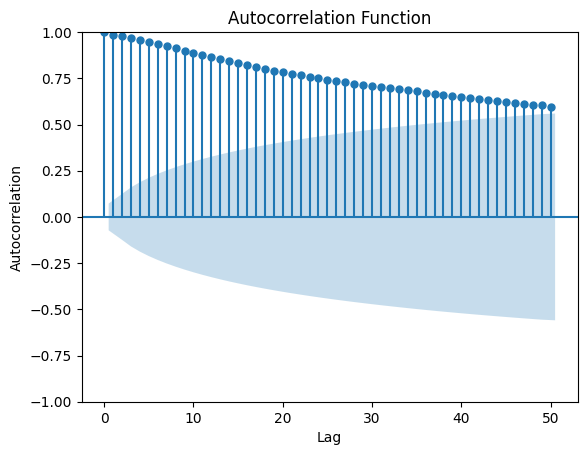

In [216]:
from statsmodels.graphics.tsaplots import plot_acf

# Autocorrelation Function Plot
plot_acf(data['Revenue'], lags=50)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Function')
plt.show()


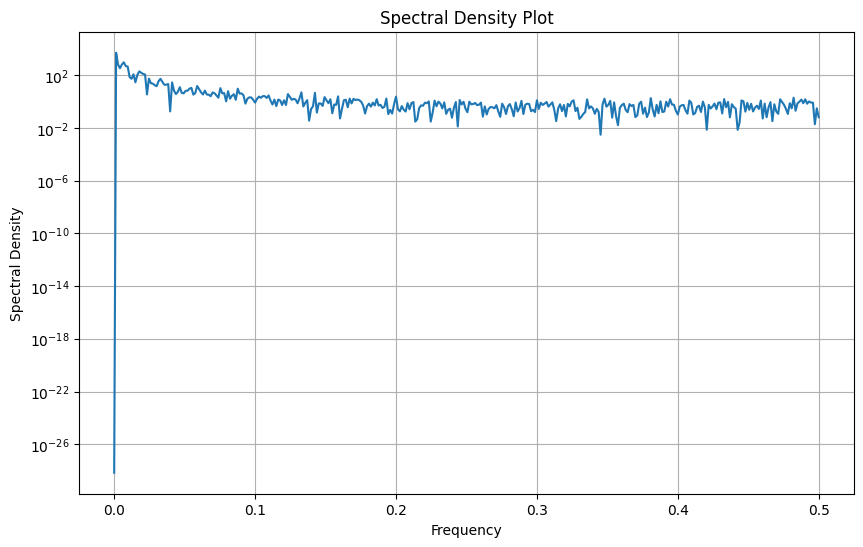

In [217]:
# Spectral Density Plot
frequencies, spectral_density = signal.periodogram(data['Revenue'])

plt.figure(figsize=(10, 6))
plt.semilogy(frequencies, spectral_density)
plt.xlabel('Frequency')
plt.ylabel('Spectral Density')
plt.title('Spectral Density Plot')
plt.grid(True)
plt.show()

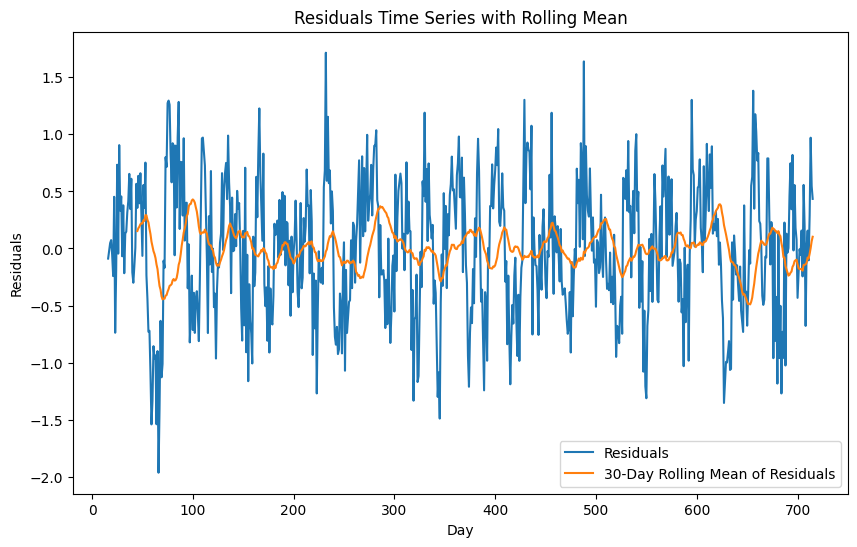

In [218]:
# Trend Analysis of Residuals
plt.figure(figsize=(10, 6))
plt.plot(result.resid, label='Residuals')
plt.plot(result.resid.rolling(window=30).mean(), label='30-Day Rolling Mean of Residuals')
plt.title('Residuals Time Series with Rolling Mean')
plt.xlabel('Day')
plt.ylabel('Residuals')
plt.legend()
plt.show()


In [219]:



# Convert day to datetime
data['Day'] = pd.to_datetime(data['Day'])
data.set_index('Day', inplace=True)

# Reindex the df
start_date = '1970-01-01'
date_range = pd.date_range(start=start_date, periods=len(data))

data.index = date_range

# Seasonal decomposition
decomposition = seasonal_decompose(data['Revenue'], period=7)
# Print the seasonal component
seasonal_component = decomposition.seasonal
print("Seasonal Component:")
print(seasonal_component)


Seasonal Component:
1970-01-01   -0.028482
1970-01-02   -0.036997
1970-01-03   -0.060849
1970-01-04   -0.043339
1970-01-05    0.062468
                ...   
1971-12-27    0.062468
1971-12-28    0.020092
1971-12-29    0.087107
1971-12-30   -0.028482
1971-12-31   -0.036997
Freq: D, Name: seasonal, Length: 730, dtype: float64


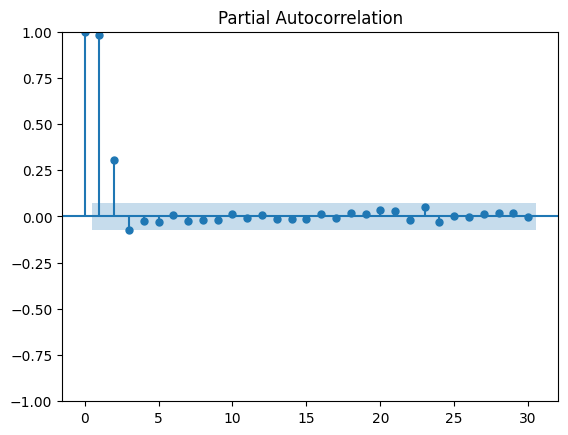

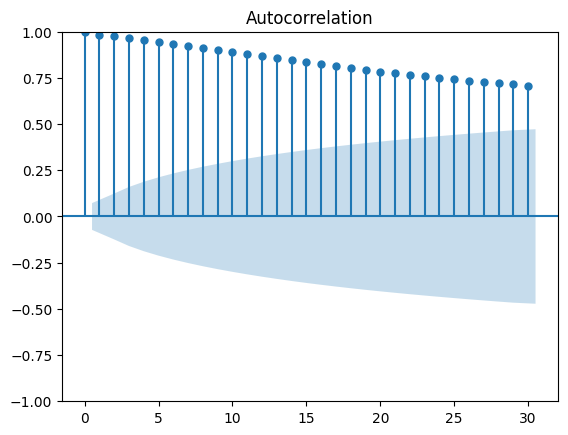

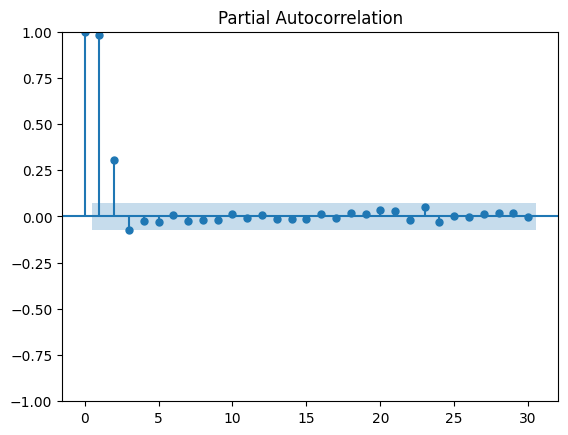

In [220]:

# Plot ACF and PACF
plot_acf(data['Revenue'], lags=30)
plot_pacf(data['Revenue'], lags=30)

In [221]:

# Model
model = sm.tsa.statespace.SARIMAX(data['Revenue'], order=(1, 1, 0), seasonal_order=(0, 1, 1, 7))
results = model.fit()

# Summary of the model
print(results.summary())



                                      SARIMAX Results                                      
Dep. Variable:                             Revenue   No. Observations:                  730
Model:             SARIMAX(1, 1, 0)x(0, 1, [1], 7)   Log Likelihood                -496.658
Date:                             Sat, 23 Dec 2023   AIC                            999.316
Time:                                     03:53:51   BIC                           1013.062
Sample:                                 01-01-1970   HQIC                          1004.622
                                      - 12-31-1971                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4712      0.034    -13.980      0.000      -0.537      -0.405
ma.S.L7       -0.9870      

In [222]:
#D5


# Load the cleaned data
data = pd.read_csv('cleaned_teleco_time_series.csv')


# Split the data into training and test sets
train_data, test_data = train_test_split(data, test_size=0.2, shuffle=False)

# Set 'day column as index
train_data.set_index('Day', inplace=True)
test_data.set_index('Day', inplace=True)

# Fit the SARIMAX model 
model = sm.tsa.statespace.SARIMAX(train_data['Revenue'], order=(1, 1, 0), seasonal_order=(0, 1, 1, 7))
results = model.fit()

# Perform Forecast for the test data
forecast = results.get_forecast(steps=len(test_data))

# Extract forecasted values
forecast_values = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

# Index
forecast_index = pd.date_range(start=test_data.index.min(), periods=len(test_data))
forecast_values.index = forecast_index
confidence_intervals.index = forecast_index

# Print 
print("Forecasted Values:")
print(forecast_values)
print("\nConfidence Intervals:")
print(confidence_intervals)



/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Forecasted Values:
1970-01-01 00:00:00.000000586    13.688886
1970-01-02 00:00:00.000000586    13.832714
1970-01-03 00:00:00.000000586    13.784297
1970-01-04 00:00:00.000000586    13.898923
1970-01-05 00:00:00.000000586    13.791198
                                   ...    
1970-05-22 00:00:00.000000586    17.011690
1970-05-23 00:00:00.000000586    16.984396
1970-05-24 00:00:00.000000586    17.089227
1970-05-25 00:00:00.000000586    16.986044
1970-05-26 00:00:00.000000586    17.002725
Freq: D, Name: predicted_mean, Length: 146, dtype: float64

Confidence Intervals:
                               lower Revenue  upper Revenue
1970-01-01 00:00:00.000000586      12.772530      14.605242
1970-01-02 00:00:00.000000586      12.792890      14.872538
1970-01-03 00:00:00.000000586      12.537207      15.031386
1970-01-04 00:00:00.000000586      12.516251      15.281594
1970-01-05 00:00:00.000000586      12.267812      15.314583
...                                      ...            ...
1970-0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [223]:
#E2


# Fit the SARIMAX model 
model = sm.tsa.statespace.SARIMAX(data['Revenue'], order=(1, 1, 0), seasonal_order=(0, 1, 1, 7))
results = model.fit()

# Perform Forecast
forecast_period = 30
forecast = results.get_forecast(steps=forecast_period)

# Extract forecasted values and associated confidence intervals
forecast_values = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

# Print
print("Forecasted Values:")
print(forecast_values)
print("\nConfidence Intervals:")
print(confidence_intervals)


Forecasted Values:
730    16.433717
731    16.537645
732    16.643812
733    16.643359
734    16.719634
735    16.616715
736    16.644425
737    16.644998
738    16.660509
739    16.808336
740    16.788254
741    16.873777
742    16.766501
743    16.796264
744    16.795870
745    16.811836
746    16.959448
747    16.939468
748    17.024943
749    16.917689
750    16.947442
751    16.947053
752    16.963017
753    17.110630
754    17.090649
755    17.176125
756    17.068871
757    17.098623
758    17.098234
759    17.114198
Name: predicted_mean, dtype: float64

Confidence Intervals:
     lower Revenue  upper Revenue
730      15.505779      17.361655
731      15.487941      17.587348
732      15.383930      17.903694
733      15.248047      18.038672
734      15.182288      18.256980
735      14.957615      18.275815
736      14.868320      18.420530
737      14.756097      18.533900
738      14.666537      18.654481
739      14.713950      18.902721
740      14.598327      18.978181
741

In [224]:
# Calculate mean absolute error
mae = abs(forecast_values - test_data['Revenue']).mean()

# Calculate mean squared error
mse = ((forecast_values - test_data['Revenue']) ** 2).mean()

# Calculate root mean squared error
rmse = mse ** 0.5

# Print the calculated error metrics
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")


Mean Absolute Error (MAE): 0.161028692618423
Mean Squared Error (MSE): 0.03199475124750358
Root Mean Squared Error (RMSE): 0.17887076688912468


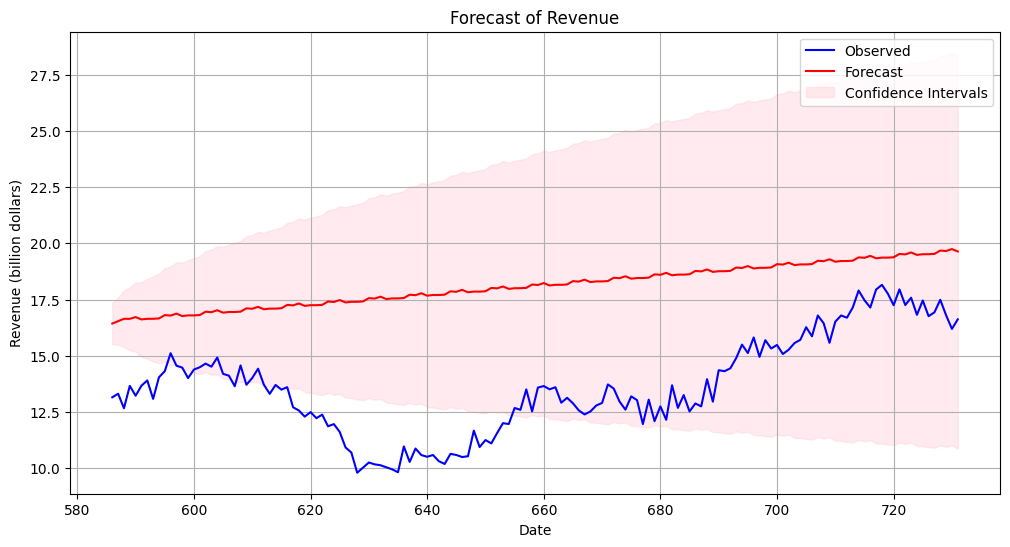

In [225]:
# Perform Forecast
forecast = results.get_forecast(steps=len(test_data))

# Extract forecasted values and confidence intervals
forecast_values = forecast.predicted_mean
confidence_intervals = forecast.conf_int()
forecast_values.index = test_data.index
confidence_intervals.index = test_data.index

# Plotting the data
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data['Revenue'], label='Observed', color='blue')
plt.plot(forecast_values.index, forecast_values, label='Forecast', color='red')
plt.fill_between(forecast_values.index, confidence_intervals.iloc[:, 0], confidence_intervals.iloc[:, 1], color='pink', alpha=0.3, label='Confidence Intervals')

# Plot
plt.title('Forecast of Revenue')
plt.xlabel('Date')
plt.ylabel('Revenue (billion dollars)')
plt.legend()
plt.grid(True)
plt.show()
